In [19]:
import pyanitools as pyt
import pyaniasetools as aat
import numpy as np
import hdnntools as hdt
import os

import matplotlib.pyplot as plt

In [20]:
file_from = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/h5files/'
file_to = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/h5files_fix/'
file_xyz = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/h5files_fix/'

wkdir = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/ANI-AL-0606.0201.0411'
#wkdir = '/home/jujuman/Research/ANI-validation/'
cnstfile = wkdir + '/train0/rHCNOSFCl-4.6A_16-3.1A_a4-8.params'
saefile  = wkdir + '/train0/sae_wb97x-631gd.dat'
nnfdir   = wkdir + '/train'
Nn = 5

In [21]:
files = os.listdir(file_from)
files.sort()

# Define the conformer cross validator class
anicv = aat.anicrossvalidationconformer(cnstfile,saefile,nnfdir,Nn,0,False)

In [22]:
pae = [] 
gidx_l = []
err_l = []
err_c = []
for k,f in enumerate(files[0:2]):
    print('Working on file:',f)
    adl = pyt.anidataloader(file_from+f)

    # Data storage
    dpack = pyt.datapacker(file_to+f)

    for i,data in enumerate(adl):
        if i == 2:
            break
        X = data['coordinates']
        S = data['species']
        Edft = hdt.hatokcal * data['energies']
        path = data['path']
        del data['path']
    
        Eani, Fani = anicv.compute_energy_conformations(X=X,S=S)
    
        Eani_m = np.mean(Eani, axis=0)
        #Fani = np.mean(Fani, axis=0)
    
        dE = Eani - Edft
        err = Eani_m - Edft 
        
        err_l.append(err/np.sqrt(float(len(S))))

        gidx = []
        for j,row in enumerate(dE.T):
            Nfail = np.where(np.abs(row/np.sqrt(len(S))) > 3.0)[0].size
            if Nfail >= 4:
                print('1:(',str(k).zfill(3),str(i).zfill(3),str(j).zfill(3),')',len(S),err[j],(Eani.T[j]-Edft[j])/np.sqrt(len(S)),Edft[j]/hdt.hatokcal)
                x = X[j].reshape(1,X.shape[1],3)
                hdt.writexyzfile(file_xyz+"check_"+str(k).zfill(3)+str(i).zfill(3)+str(j).zfill(3)+".xyz",x,S)
            elif Nfail < 4 and np.abs(err[j]/np.sqrt(len(S))) > 8.0:
                print('2:(',str(k).zfill(3),str(i).zfill(3),str(j).zfill(3),')',len(S),err[j],(Eani.T[j]-Edft[j])/np.sqrt(len(S)),Edft[j]/hdt.hatokcal)
                x = X[j].reshape(1,X.shape[1],3)
                hdt.writexyzfile(file_xyz+"check_"+str(k).zfill(3)+str(i).zfill(3)+str(j).zfill(3)+".xyz",x,S)
            else:
                gidx.append(j)
        gidx_l.append(np.array(gidx))      
        klist = ['cm5', 'hirshfeld', 'hirdipole', 'forces', 'coordinates', 'spindensities', 'energies']

        err_c.append(err[gidx]/np.sqrt(float(len(S))))
        data_new = data.copy()
        for key in klist:
            data_new[key] = data[key][gidx]
            print(key,type(data[key][0]),type(data_new[key][0]),type(data[key][gidx][0]))
            
        dpack.store_data(path, **data_new)
print('done')
dpack.cleanup()
err_l = np.concatenate(err_l)
err_c = np.concatenate(err_c)

Working on file: ANI-AL-0605.0000.0001.h5


OSError: Unable to create file (Unable to open file: name = '/home/jujuman/research/datareductionmethods/h5_stats_check/h5files_fix/ani-al-0605.0000.0001.h5', errno = 17, error message = 'file exists', flags = 15, o_flags = c2)

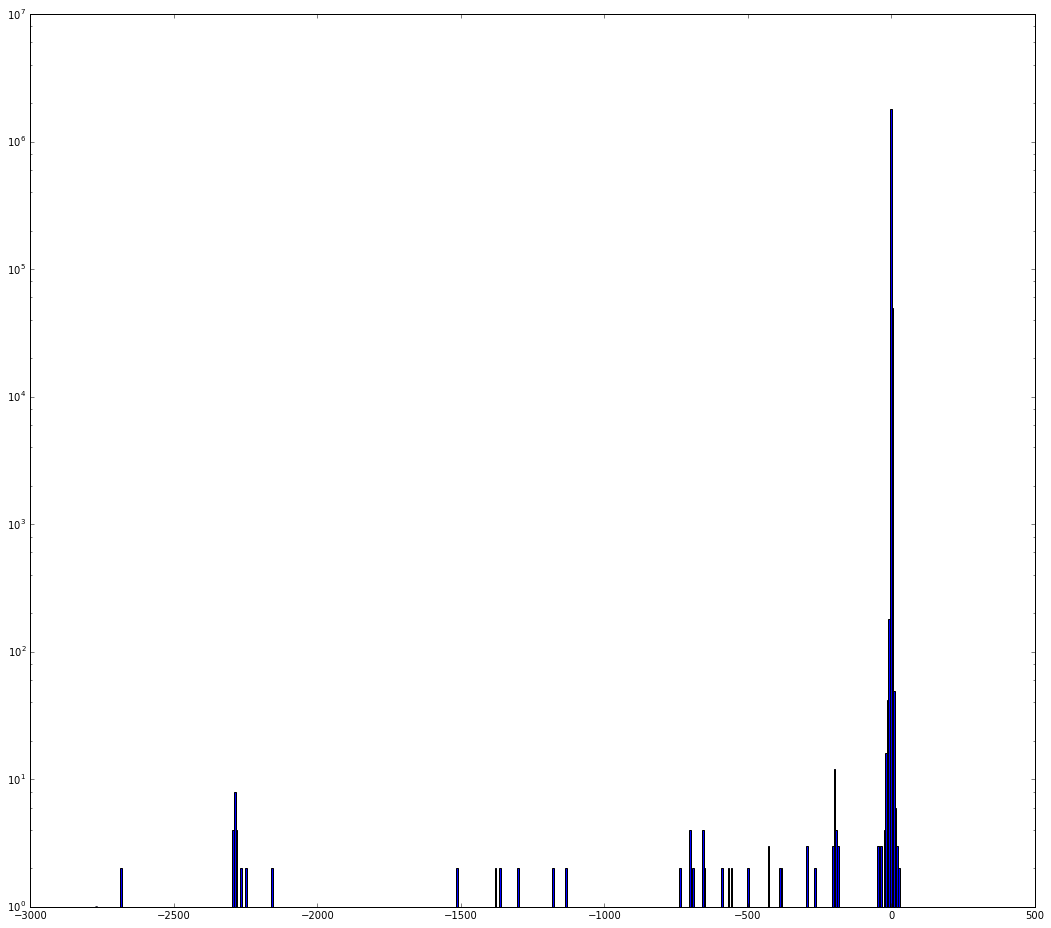

In [8]:
fig=plt.figure(figsize=(18, 16))
err_2 = err_l[np.where(np.abs(err_l) < 20.0)]
plt.hist(err_l, bins=500)
plt.gca().set_yscale("log")
plt.show()

7.98087571084


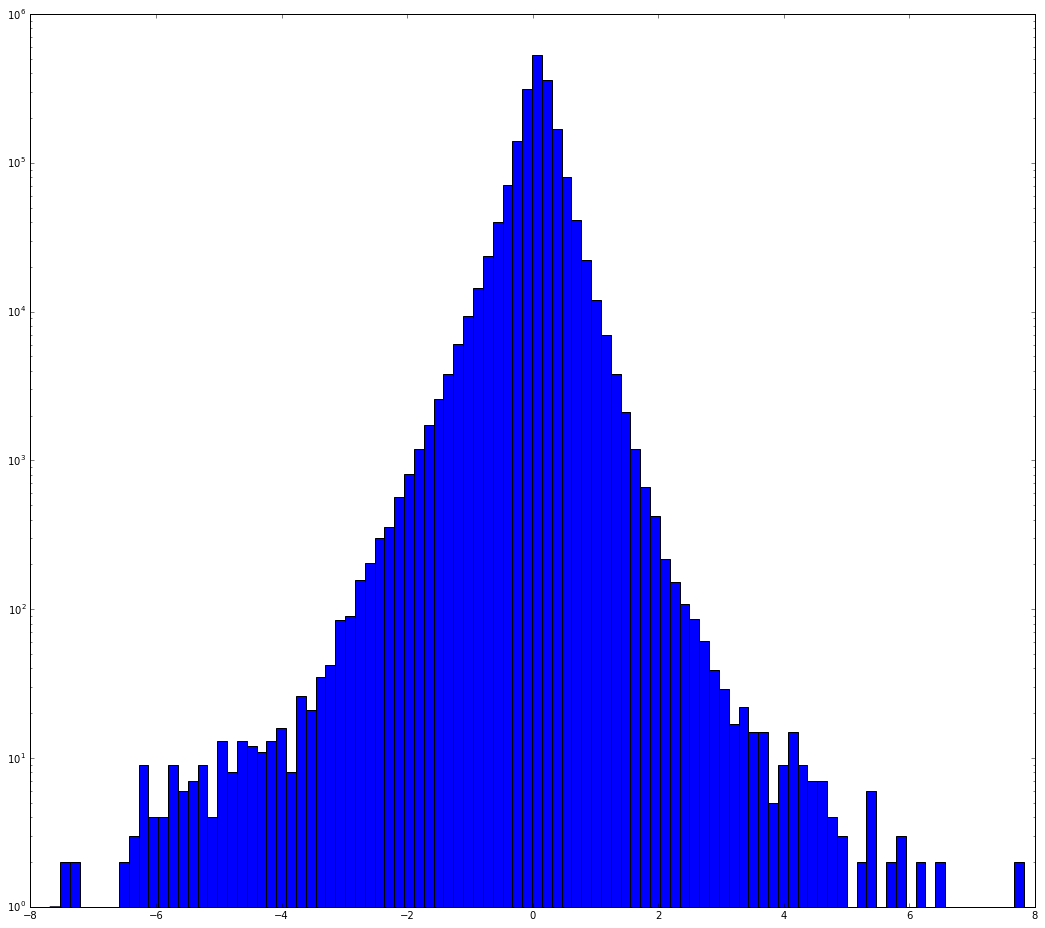

In [9]:
print(np.abs(err_c).max())
fig=plt.figure(figsize=(18, 16))
#err_2 = err_l[np.where(np.abs(err_l) < 20.0)]
plt.hist(err_c, bins=100)
plt.gca().set_yscale("log")
plt.show()

In [ ]:
bi = np.where(pae > 0.15)

Nt = pae.size
Nb = bi[0].size


print(Nb,'/',Nt,' = ',Nb/float(Nt))

In [ ]:
adl = pyt.anidataloader(file_to)
for data in adl:
    X = data['coordinates']
    S = data['species']
    Edft = hdt.hatokcal * data['energies']
    
    Eani, Fani = anicv.compute_energy_conformations(X=X,S=S)
    
    Eani = np.mean(Eani, axis=0)
    Fani = np.mean(Fani, axis=0)
    
    print(hdt.calculaterootmeansqrerror(Eani,Edft))
    